In [17]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

In [18]:
df = pd.read_csv("/Users/iguacio/Documents/Datathon Vivaaerobus/Filghts TEC_Valid.csv")

We remove data beyond 2023, as it will be used for prediction. It's saved for later.

In [19]:
df['STD'] = pd.to_datetime(df['STD'])
df['STA'] = pd.to_datetime(df['STA'])

In [20]:
datos2024 = df.loc[df['STD'].dt.year > 2024]

In [21]:
df = df[df['STD'].dt.year < 2024]

We remove entries that lack aircraft information.

In [22]:
df = df.dropna()

Extract flight time.

In [23]:
df['tiempoVuelo'] = df['STA'] - df['STD']
df['tiempoVuelo'] = df['tiempoVuelo'] / np.timedelta64(1, 'm')
datos2024['tiempoVuelo'] = datos2024['STA'] - datos2024['STD']
datos2024['tiempoVuelo'] = datos2024['tiempoVuelo'] / np.timedelta64(1, 'm')

In [24]:
columns_to_encode = [ "Destination_Type", "Origin_Type"]
df = pd.concat([df, pd.get_dummies(df[columns_to_encode])], axis=1)
df.drop(columns=columns_to_encode, inplace=True)
df.drop(columns=["Aeronave",'DepartureStation', "ArrivalStation"], inplace=True)

In [25]:
df

,Flight_ID,STD,STA,Capacity,Passengers,Bookings,tiempoVuelo,Destination_Type_Ciudad Fronteriza,Destination_Type_Ciudad Principal,Destination_Type_Ecoturismo,Destination_Type_MX Amigos y Familia,Destination_Type_Playa,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,Origin_Type_MX Amigos y Familia,Origin_Type_Playa
0,ab954014077430bd842cfa305a55c0f8,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0,165.0,True,False,False,False,False,False,True,False,False,False
1,efd86c996035dacdca7a0ccb2560dda1,2023-07-03 00:55:00,2023-07-03 04:55:00,186,197.0,109.0,240.0,False,False,False,True,False,True,False,False,False,False
3,dd0fad3248951d2f71d63e6279aeaa4b,2023-06-26 15:15:00,2023-06-26 15:55:00,220,200.0,142.0,40.0,False,False,False,True,False,False,True,False,False,False
4,d0987ee648eea254063bfe2b39571b67,2023-02-10 08:40:00,2023-02-10 09:50:00,186,162.0,90.0,70.0,False,False,False,False,True,False,True,False,False,False
5,3b5df8805161ea827d2f2e4298c38e06,2023-09-07 17:10:00,2023-09-07 18:05:00,240,183.0,125.0,55.0,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245718,d9ef769565064b1ff1ad90d6d18f69cb,2023-12-26 06:20:00,2023-12-26 10:10:00,180,166.0,89.0,230.0,False,False,False,False,True,False,True,False,False,False
245745,598035669a4f0fa2ce1207977932df9e,2023-12-28 10:25:00,2023-12-28 13:50:00,180,142.0,54.0,205.0,False,False,False,False,True,False,True,False,False,False
245747,90d2cab80b7700b5d854ae393678144b,2023-12-23 11:45:00,2023-12-23 15:00:00,180,156.0,61.0,195.0,False,False,False,False,True,False,True,False,False,False
245748,cc7c1c5e6fd132fd0bdab3a35aac33c0,2023-12-29 07:30:00,2023-12-29 14:50:00,240,189.0,86.0,440.0,False,False,False,False,True,True,False,False,False,False


In [26]:
columns_to_encode = [ "Destination_Type", "Origin_Type"]
datos2024 = pd.concat([datos2024, pd.get_dummies(datos2024[columns_to_encode])], axis=1)
datos2024.drop(columns=columns_to_encode, inplace=True)
datos2024.drop(columns=["Aeronave",'DepartureStation', "ArrivalStation"], inplace=True)


Because they are cyclical, we encode them using sine and cosine functions to help the neural network understand continuity between the end and beginning of the cycle.

In [27]:
df['hour_sinSalida'] = np.sin(2 * np.pi * df['STD'].dt.hour / 24)
df['hour_cosSalida'] = np.cos(2 * np.pi * df['STD'].dt.hour / 24)
df['day_of_week_sinSalida'] = np.sin(2 * np.pi *  df['STD'].dt.dayofweek / 7)
df['day_of_week_cosSalida'] = np.cos(2 * np.pi *  df['STD'].dt.dayofweek / 7)
df['month_sinSalida'] = np.sin(2 * np.pi * df['STD'].dt.month / 12)
df['month_cosSalida'] = np.cos(2 * np.pi * df['STD'].dt.month/ 12)
df.drop(columns="STD", inplace=True)

In [28]:
df['hour_sinLlegada'] = np.sin(2 * np.pi * df['STA'].dt.hour / 24)
df['hour_cosLlegada'] = np.cos(2 * np.pi * df['STA'].dt.hour / 24)
df['day_of_week_sinLlegada'] = np.sin(2 * np.pi *  df['STA'].dt.dayofweek / 7)
df['day_of_week_cosLlegada'] = np.cos(2 * np.pi *  df['STA'].dt.dayofweek / 7)
df['month_sinLlegada'] = np.sin(2 * np.pi * df['STA'].dt.month / 12)
df['month_cosLlegada'] = np.cos(2 * np.pi * df['STA'].dt.month/ 12)
df.drop(columns="STA", inplace=True)

In [29]:
datos2024['hour_sinSalida'] = np.sin(2 * np.pi * datos2024['STD'].dt.hour / 24)
datos2024['hour_cosSalida'] = np.cos(2 * np.pi * datos2024['STD'].dt.hour / 24)
datos2024['day_of_week_sinSalida'] = np.sin(2 * np.pi *  datos2024['STD'].dt.dayofweek / 7)
datos2024['day_of_week_cosSalida'] = np.cos(2 * np.pi *  datos2024['STD'].dt.dayofweek / 7)
datos2024['month_sinSalida'] = np.sin(2 * np.pi * datos2024['STD'].dt.month / 12)
datos2024['month_cosSalida'] = np.cos(2 * np.pi * datos2024['STD'].dt.month/ 12)
datos2024.drop(columns="STD", inplace=True)

In [30]:
datos2024['hour_sinLlegada'] = np.sin(2 * np.pi * datos2024['STA'].dt.hour / 24)
datos2024['hour_cosLlegada'] = np.cos(2 * np.pi * datos2024['STA'].dt.hour / 24)
datos2024['day_of_week_sinLlegada'] = np.sin(2 * np.pi *  datos2024['STA'].dt.dayofweek / 7)
datos2024['day_of_week_cosLlegada'] = np.cos(2 * np.pi *  datos2024['STA'].dt.dayofweek / 7)
datos2024['month_sinLlegada'] = np.sin(2 * np.pi * datos2024['STA'].dt.month / 12)
datos2024['month_cosLlegada'] = np.cos(2 * np.pi * datos2024['STA'].dt.month/ 12)
datos2024.drop(columns="STA", inplace=True)

If the flight was oversold, we cap the value at the aircraft’s maximum capacity.

In [31]:
df1 = df

In [32]:
df1['Passengers'] = df1.apply(lambda row: row['Capacity'] if row['Passengers'] > row['Capacity'] else row['Passengers'], axis=1)

We remove outliers from flights with very few passengers.

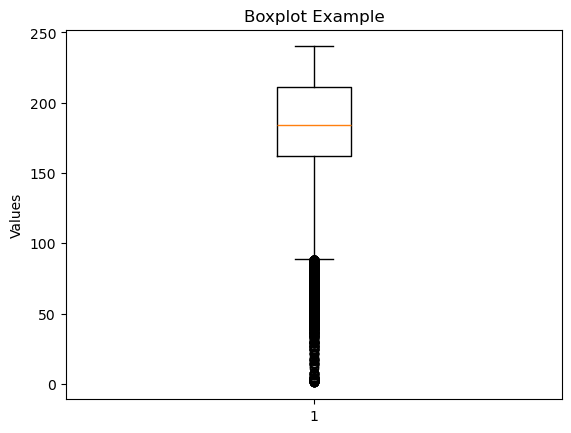

In [33]:
plt.boxplot(df1["Passengers"])

# Add title and labels
plt.title('Boxplot Example')
plt.ylabel('Values')

# Show the plot
plt.show()

In [34]:

Q1 = df1["Passengers"].quantile(0.25)
Q3 = df1["Passengers"].quantile(0.75)
IQR = Q3 - Q1

# Define the boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where the column value is outside the boundaries
df_filtered1 = df1[(df1["Passengers"] >= lower_bound) & (df1["Passengers"] <= upper_bound)]


In [35]:
df = df_filtered1

# test model

In [40]:
df.to_csv('datosvuelosfinal.csv', index=False)

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [38]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(24, X_train.shape[1])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

In [ ]:
model.fit(X_scaled, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 25), dtype=float32). Expected shape (None, 24, 25), but input has incompatible shape (None, 25)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 25), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Assuming X_test is your test dataset
predictions = model.predict(X_test)

751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 183.56410112241753


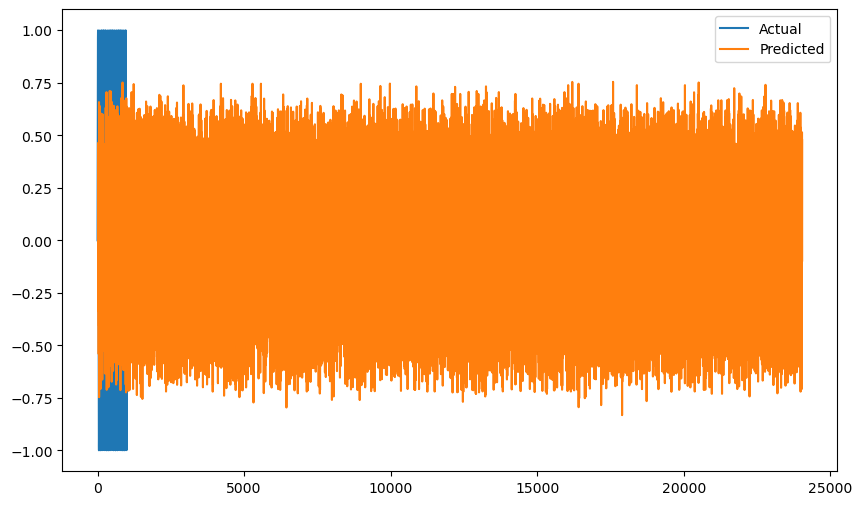

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(np.arange(window_size, len(predictions) + window_size), predictions.flatten(), label='Predicted')
plt.legend()
plt.show()

# fourth model

In [ ]:
y = df["Passengers"].values
X = df.drop(columns=["Passengers","Flight_ID"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Construcción del modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Uso de activación lineal para regresión
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=64)

# Evaluación del modelo
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')


Epoch 1/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step - loss: 1613.5311 - mae: 24.0454
Epoch 2/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 342.9478 - mae: 14.0764
Epoch 3/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 320.6945 - mae: 13.5997
Epoch 4/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 310.5746 - mae: 13.3407
Epoch 5/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 297.3997 - mae: 13.0423
Epoch 6/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 291.6074 - mae: 12.8574
Epoch 7/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 287.9901 - mae: 12.7356
Epoch 8/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - loss: 284.4062 - mae: 12.6557
Epoch 9/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 280.2627 - mae: 12.5612
Epoch 10/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - loss: 281.0797 - mae: 12.5672
Epoch 11/200
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1s 380us/step - loss: 270.5023 - mae: 12.2786
Epoch 12/200
1501/

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)

751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 355.6146 - mae: 14.0090


751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


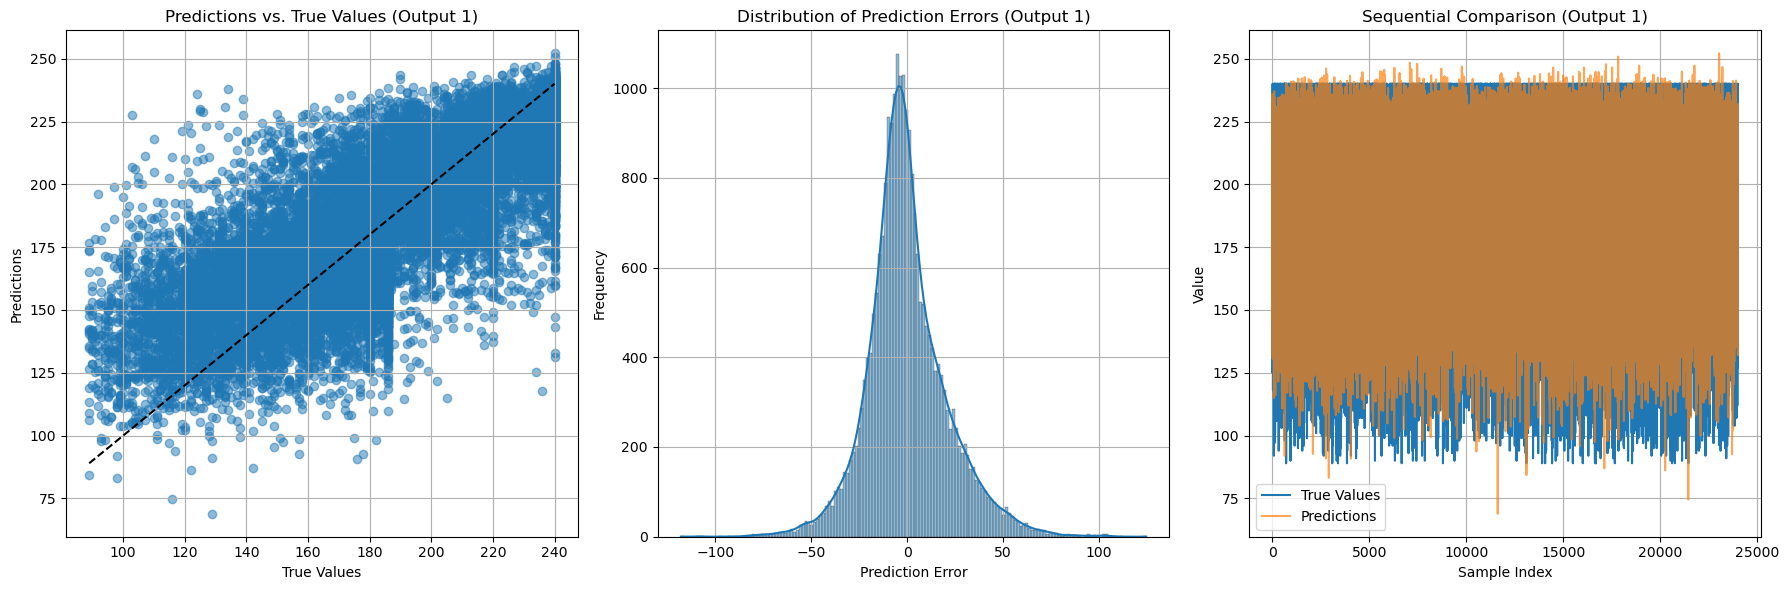

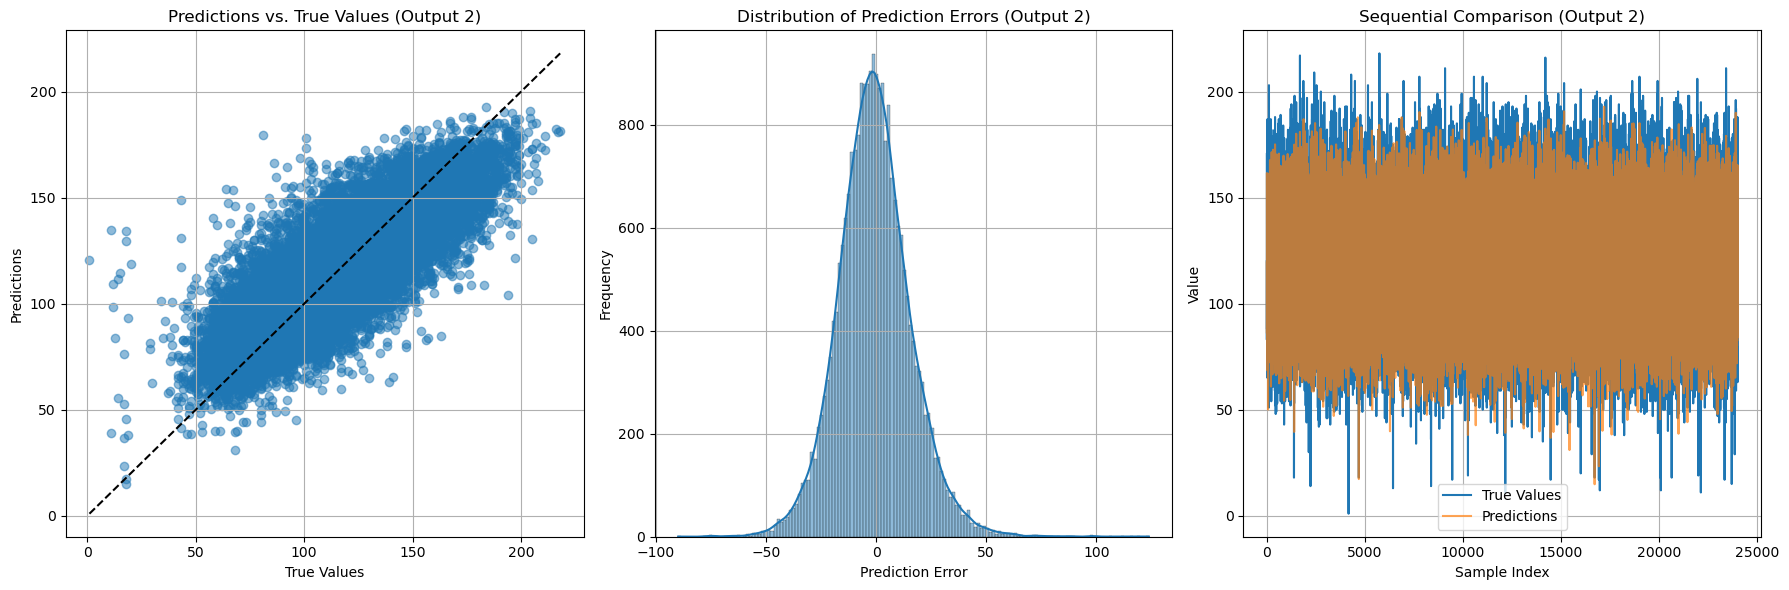

In [ ]:
# Assuming model is already trained
predictions = model.predict(X_test)
num_outputs = y_test.shape[1]  # Number of output dimensions

# Loop through each output dimension
for i in range(num_outputs):
    true_values = y_test[:, i]
    predicted_values = predictions[:, i]

    # Create subplots: 1 row, 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Scatter Plot of Predictions vs True Values
    axs[0].scatter(true_values, predicted_values, alpha=0.5)
    axs[0].set_title(f'Predictions vs. True Values (Output {i+1})')
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predictions')
    axs[0].plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--')  # Diagonal line
    axs[0].grid(True)

    # Histogram of Prediction Errors
    errors = predicted_values - true_values
    sns.histplot(errors, kde=True, ax=axs[1])
    axs[1].set_title(f'Distribution of Prediction Errors (Output {i+1})')
    axs[1].set_xlabel('Prediction Error')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    # Line Plot for Sequential Data
    axs[2].plot(true_values, label='True Values')
    axs[2].plot(predicted_values, label='Predictions', alpha=0.7)
    axs[2].set_title(f'Sequential Comparison (Output {i+1})')
    axs[2].set_xlabel('Sample Index')
    axs[2].set_ylabel('Value')
    axs[2].legend()
    axs[2].grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()


In [ ]:
datos2024.drop(columns=["Passengers", "Bookings", "Flight_ID"], inplace=True)

In [ ]:
predictions = model.predict(datos2024)

2024-05-05 01:45:17.245226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,101], In[1]: [190,128]
	 [[{{node sequential_262_1/dense_588_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_262_1/dense_588_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/1h/w3mjcszn60577hhjww35tglh0000gn/T/ipykernel_17463/249405449.py", line 1, in <module>

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 504, in predict

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 204, in one_step_on_data_distributed

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 194, in one_step_on_data

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 92, in predict_step

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/models/functional.py", line 202, in call

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/models/functional.py", line 592, in call

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/layers/core/dense.py", line 150, in call

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 3440, in matmul

  File "/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 475, in matmul

Matrix size-incompatible: In[0]: [32,101], In[1]: [190,128]
	 [[{{node sequential_262_1/dense_588_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_39745120]

In [ ]:
X_train

,Capacity,tiempoVuelo,Aeronave_9H-SWB,Aeronave_9H-SWJ,Aeronave_9H-SWM,Aeronave_XA-VAA,Aeronave_XA-VAB,Aeronave_XA-VAC,Aeronave_XA-VAE,Aeronave_XA-VAI,...,day_of_week_sinSalida,day_of_week_cosSalida,month_sinSalida,month_cosSalida,hour_sinLlegada,hour_cosLlegada,day_of_week_sinLlegada,day_of_week_cosLlegada,month_sinLlegada,month_cosLlegada
158410,186,80.0,False,False,False,False,False,False,False,False,...,-0.433884,-0.900969,1.000000e+00,6.123234e-17,-5.000000e-01,8.660254e-01,-0.433884,-0.900969,1.000000e+00,6.123234e-17
124595,240,225.0,False,False,False,False,False,False,False,False,...,-0.974928,-0.222521,-8.660254e-01,5.000000e-01,-2.588190e-01,9.659258e-01,-0.974928,-0.222521,-8.660254e-01,5.000000e-01
28319,220,195.0,False,False,False,False,False,False,False,False,...,-0.781831,0.623490,1.000000e+00,6.123234e-17,-2.588190e-01,-9.659258e-01,-0.781831,0.623490,1.000000e+00,6.123234e-17
168104,180,135.0,False,False,False,False,False,False,False,False,...,0.974928,-0.222521,8.660254e-01,-5.000000e-01,-8.660254e-01,5.000000e-01,0.974928,-0.222521,8.660254e-01,-5.000000e-01
136142,186,90.0,False,False,False,False,False,False,False,False,...,0.974928,-0.222521,5.000000e-01,-8.660254e-01,-8.660254e-01,5.000000e-01,0.974928,-0.222521,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224897,220,65.0,False,False,False,False,False,False,False,False,...,0.000000,1.000000,-2.449294e-16,1.000000e+00,1.224647e-16,-1.000000e+00,0.000000,1.000000,-2.449294e-16,1.000000e+00
244348,186,25.0,False,False,False,False,False,False,False,False,...,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,1.000000e+00,6.123234e-17,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16
211690,186,125.0,False,False,False,False,False,False,False,False,...,-0.433884,-0.900969,5.000000e-01,8.660254e-01,-9.659258e-01,-2.588190e-01,-0.433884,-0.900969,5.000000e-01,8.660254e-01
1608,180,60.0,False,False,False,False,False,False,False,False,...,-0.974928,-0.222521,8.660254e-01,5.000000e-01,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,8.660254e-01,5.000000e-01


In [ ]:
datos2024

,Capacity,tiempoVuelo,DepartureStation_AB,DepartureStation_AD,DepartureStation_AE,DepartureStation_AF,DepartureStation_AI,DepartureStation_AJ,DepartureStation_AK,DepartureStation_AL,...,day_of_week_sinSalida,day_of_week_cosSalida,month_sinSalida,month_cosSalida,hour_sinLlegada,hour_cosLlegada,day_of_week_sinLlegada,day_of_week_cosLlegada,month_sinLlegada,month_cosLlegada
106,180,75.0,False,False,False,False,False,False,False,False,...,0.974928,-0.222521,0.5,0.866025,-0.866025,-0.500000,0.974928,-0.222521,0.5,0.866025
116,180,45.0,False,False,False,False,False,False,False,False,...,0.000000,1.000000,0.5,0.866025,-0.258819,-0.965926,0.000000,1.000000,0.5,0.866025
246,180,75.0,False,False,False,False,False,False,False,False,...,0.433884,-0.900969,0.5,0.866025,-0.866025,-0.500000,0.433884,-0.900969,0.5,0.866025
339,186,100.0,False,False,False,False,False,False,False,False,...,0.781831,0.623490,0.5,0.866025,0.500000,-0.866025,0.781831,0.623490,0.5,0.866025
345,180,50.0,False,False,False,False,False,False,False,False,...,0.000000,1.000000,0.5,0.866025,-0.866025,0.500000,0.000000,1.000000,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245185,180,200.0,False,False,False,False,False,False,False,False,...,-0.781831,0.623490,0.5,0.866025,-0.500000,-0.866025,-0.781831,0.623490,0.5,0.866025
245303,240,180.0,False,False,False,False,False,False,False,False,...,-0.433884,-0.900969,0.5,0.866025,-0.707107,-0.707107,-0.433884,-0.900969,0.5,0.866025
245364,240,180.0,False,False,False,False,False,False,False,False,...,-0.433884,-0.900969,0.5,0.866025,-0.707107,-0.707107,-0.433884,-0.900969,0.5,0.866025
245384,240,180.0,False,False,False,False,False,False,False,False,...,0.974928,-0.222521,0.5,0.866025,-0.707107,-0.707107,0.974928,-0.222521,0.5,0.866025
